## Monitor a model
We want to show a simple showcase of model monitoring. In this case we will show how to use tools that can check if there is some data drift happening.

### 1. Extract Audio Features
This function, `extract_features`, takes a file path as input and extracts several features from the audio file:
- **MFCCs**: Mel-Frequency Cepstral Coefficients capture spectral characteristics of the audio.
- **Spectral Centroid**: Represents the "center of mass" of the spectrum.
- **Spectral Contrast**: Measures the difference between peaks and valleys in the sound spectrum.
- **Zero-Crossing Rate**: Represents the rate at which the signal changes sign.

The function returns these features as a single concatenated array.

### 2. Load Audio Files and Extract Features
We load audio files from a directory. 

We then split these into two sets to represent:
- **Reference Data**: Audio data used as the baseline.
- **Current Data**: New audio data on which we’ll simulate data drift.


In [113]:
import numpy as np
import pandas as pd
import librosa
import glob

# corrupt audio with noise (simulate data distribution drift)
def add_drift_to_audio(audio_samples, noise_level=0.05):
    return audio_samples + np.random.normal(0, noise_level, audio_samples.shape)

# extract MFCCs and other audio features
def extract_features(y, sr, n_mfcc=4):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
    return np.concatenate([mfccs.mean(axis=1), [spectral_centroid, spectral_contrast, zero_crossing_rate]])
    # concatenate all features
    # return np.array([spectral_centroid, spectral_contrast, zero_crossing_rate])

# Get file paths for audio files (only for demonstration purposes we use the one subset of a dataset)
# file_paths = glob.glob("../data/nort3160/common_voice_17_0/da/da/audio/test/*.mp3")
file_paths = glob.glob("../data/nort3160/ravnursson/fo/fo/audio/test/*.flac.wav")

# take only 10 files for demonstration purposes
file_paths = file_paths[:10]
split_index = len(file_paths) // 2

reference_files = file_paths[:split_index]
current_files = file_paths[split_index:]

print(len(reference_files), len(current_files))

# extract features for reference data (original audio)
n_mfcc = 4
reference_data = []
for file in reference_files:
    y, sr = librosa.load(file)
    features = extract_features(y, sr, n_mfcc=n_mfcc)
    reference_data.append(features)
reference_data = pd.DataFrame(reference_data)


5 5


## Understanding Data Drift in Audio Data

### What is Data Drift?

Data drift occurs when the statistical properties of data change over time, often impacting the performance of machine learning models. In audio data, this can be caused by variations in recording conditions, devices, or the audio sources themselves. Detecting and accounting for data drift is essential to ensure the robustness and accuracy of models, especially in scenarios where data quality can fluctuate.

### Causes of Data Drift in Crowd-Sourced Audio Data

In crowd-sourced audio data collection, various factors can contribute to data drift over time. Some of the common causes include:

1. **Environmental Noise**:
   - Recordings may be collected in uncontrolled environments, such as streets, offices, or homes, where background noise can vary significantly. Noise sources, including traffic, conversations, or electronic devices, can impact the quality and characteristics of the audio.
   - High levels of background noise can change the distribution of audio features, such as Mel-frequency cepstral coefficients (MFCCs), making new data appear different from the initial training data.

2. **Recording Devices and Quality**:
   - Crowd-sourced data often comes from a range of recording devices, from professional microphones to smartphone mics. The quality of these devices varies greatly, affecting sound clarity, dynamic range, and frequency response.
   - Differences in device quality introduce subtle (or sometimes significant) distortions, which can impact the extracted features and make newer recordings differ from the reference data.

3. **Speaker Variability**:
   - In cases where different individuals contribute recordings, variations in voice pitch, speaking speed, and pronunciation can create a drift in the data.
   - This variability can lead to changes in features like spectral centroid and zero-crossing rate, potentially impacting the model's ability to generalize.

4. **Changes in Audio Processing Pipelines**:
   - Updates to preprocessing techniques or feature extraction methods can inadvertently introduce drift. For example, if the way audio data is normalized or filtered changes, the resulting features may differ from those in previous versions of the data.

By monitoring data drift, we can track changes in audio data over time, identify the need for model retraining, and maintain model performance. Evidently AI enables us to detect and visualize data drift, allowing us to proactively respond to such changes.

### Simulation of Data Drift
We simulate data drift by introducing noise from a normal distribution to audio features and use Evidently AI to identify and assess the impact of this drift. This simulation helps us understand how real-world factors—such as background noise and device quality differences—could affect our models in production environments.


In [114]:
current_data = []
current_data_drifted = []
noise_level = 0.01
y_original = sr_original = y_drifted = sr_drifted = None

for idx, file in enumerate(current_files):
    y, sr = librosa.load(file)
    original_features = extract_features(y, sr)
    current_data.append(original_features)
    
    # add noise to create drifted audio, then extract features
    drifted_y = add_drift_to_audio(y, noise_level=noise_level)
    drifted_features = extract_features(drifted_y, sr)
    current_data_drifted.append(drifted_features)

    if idx == 0:
        # save the first for demonstration purposes
        y_original, sr_original = y, sr
        y_drifted, sr_drifted = drifted_y, sr

current_data = pd.DataFrame(current_data)
current_data_drifted = pd.DataFrame(current_data_drifted)

# rename columns to match the feature names (for evidently ai)
feature_columns = [f'mfcc_{i}' for i in range(n_mfcc)] + ['spectral_centroid', 'spectral_contrast', 'zero_crossing_rate']
reference_data.columns = feature_columns
current_data_drifted.columns = feature_columns

# print("Reference Data:\n", reference_data.head())
# print("Current Data:\n", current_data.head())
# print("Current Data (Drifted):\n", current_data_drifted.head())


### Plot a sample data so see and hear the differences

We want to shows how exaggerated data drift would look like

In [115]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display

def plot_waveform_and_spectrogram(audio, sr, title):
    plt.figure(figsize=(12, 6))

    # waveform
    plt.subplot(2, 1, 1)
    plt.plot(audio, color='gray')
    plt.title(f"{title} - Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    # spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title} - Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

Original Audio:


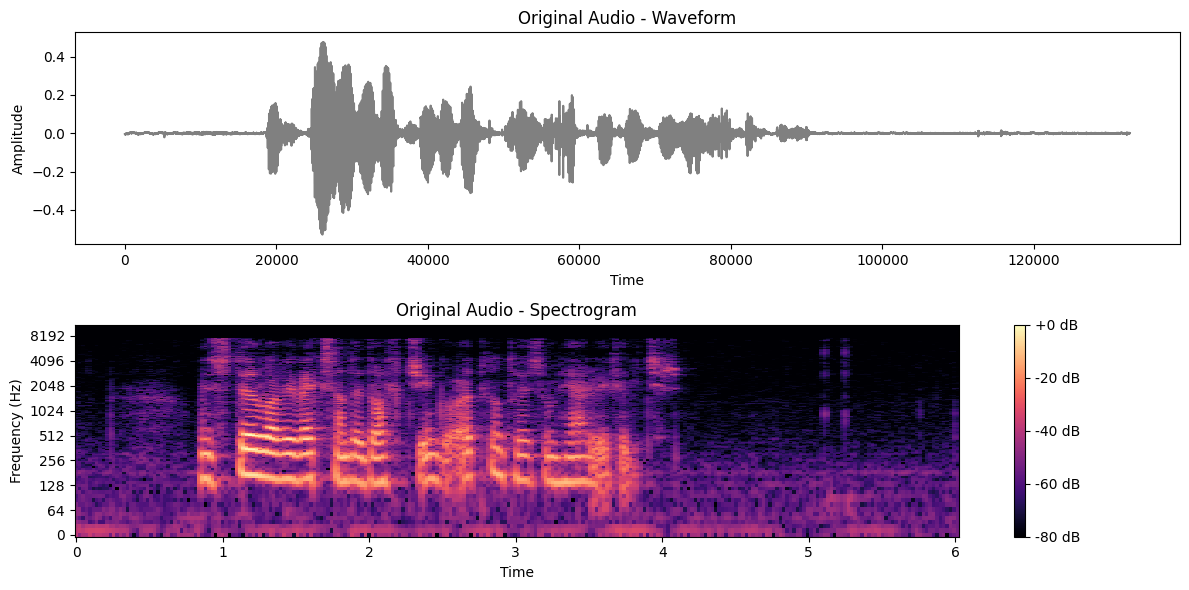

Drifted Audio with Noise:


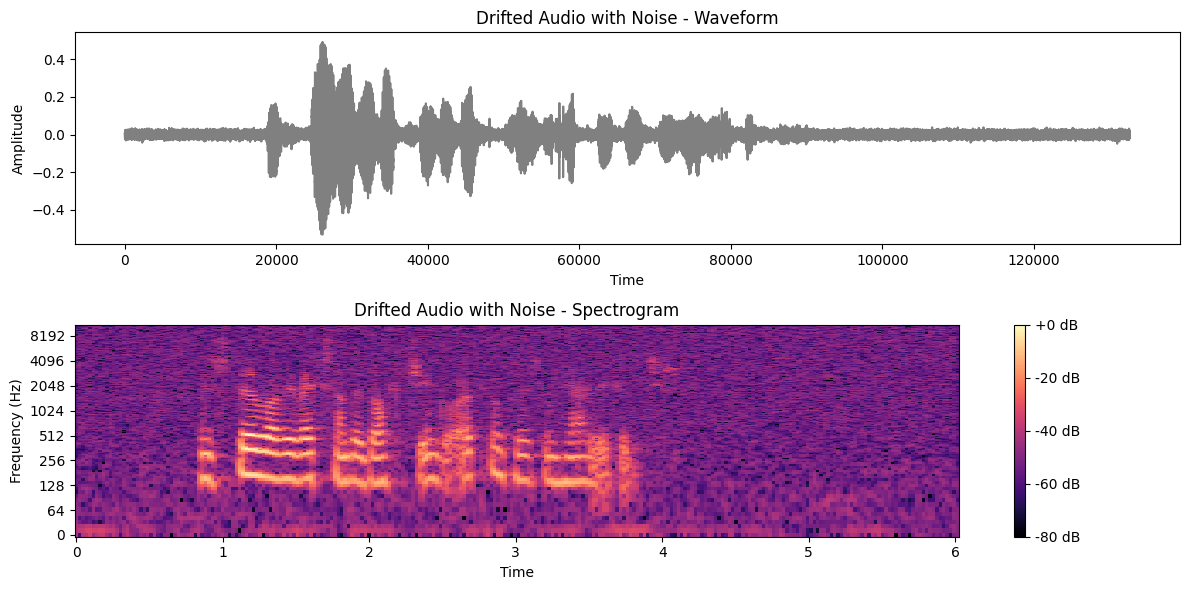

In [116]:
print("Original Audio:")
display(Audio(y_original, rate=sr_original))
plot_waveform_and_spectrogram(y_original, sr_original, "Original Audio")

print("Drifted Audio with Noise:")
display(Audio(y_drifted, rate=sr_original))
plot_waveform_and_spectrogram(y_drifted, sr_original, "Drifted Audio with Noise")


In [117]:
reference_data

mfcc_0      mfcc_1    mfcc_2     mfcc_3  spectral_centroid  \
0 -394.316711  112.904663 -3.175613  36.149559        1631.594778   
1 -443.998199  107.426826  4.832191  34.393230        1614.783499   
2 -389.403992  106.833969 -3.123030  20.364445        1619.813046   
3 -412.026062  120.055016  1.858570  47.538132        1470.663836   
4 -380.227142  130.956741 -6.930305  21.453793        1424.641230   

   spectral_contrast  zero_crossing_rate  
0          22.890836            0.076780  
1          21.782565            0.062298  
2          23.393874            0.070746  
3          22.183839            0.067652  
4          24.351611            0.053121

In [118]:
current_data_drifted

mfcc_0     mfcc_1     mfcc_2     mfcc_3  spectral_centroid  \
0 -217.259330  25.766749  11.393971   8.130195        4424.711166   
1 -208.511656  30.984161   8.940125   6.804082        4364.422208   
2 -199.542484  33.984783  12.439089  14.584093        4142.054372   
3 -223.668351  20.613348  10.257232  10.023686        4724.762161   
4 -203.193730  38.249800  10.866555   3.655037        3965.841648   

   spectral_contrast  zero_crossing_rate  
0          14.143891            0.334773  
1          14.280106            0.329078  
2          14.323925            0.307778  
3          13.382630            0.377524  
4          15.159468            0.258895

### Use Evidently AI to analyze and visualize the differences between the reference dataset and the current dataset with drift.


In [119]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

DRIFT_THRESHOLD = 0.1
# we can select the specific feature we want to use to detect drift
# drift_share is a global threshold that determines the percentage of columns that need to be flagged as drifted for Evidently to raise an alert
data_drift_report = Report(metrics=[
        DataDriftPreset(columns=['spectral_centroid', 'spectral_contrast', 'zero_crossing_rate'], drift_share=DRIFT_THRESHOLD),     
        # DataQualityPreset()
    ])


# wun the report on reference_data (original) and current_data_drifted (corrupted)
data_drift_report.run(current_data=current_data_drifted,
                      reference_data=reference_data,
                      column_mapping=None)


data_drift_report.show()

In [120]:
# Extract drift metrics and log results
drift_results = data_drift_report.as_dict()
data_drift_results = drift_results['metrics'][1]['result']


In [121]:
drifted_columns = {}
for column, drift_info in data_drift_results['drift_by_columns'].items():
    if drift_info['drift_detected']:
        drifted_columns[column] = drift_info['drift_score']

print("Drifted Columns and Scores:")
for col, score in drifted_columns.items():
    print(f"{col}: {score}")

Drifted Columns and Scores:
spectral_centroid: 0.007936507936507936
spectral_contrast: 0.007936507936507936
zero_crossing_rate: 0.007936507936507936


### what we can use as monitor:
We use the drift score for data drift detection, **drift_score:** this is often a p-value from a statistical test assessing whether a feature has drifted.

In [122]:
for feature, metrics in data_drift_results['drift_by_columns'].items():
    drift_score = metrics['drift_score'] 
    is_drifted = metrics['drift_detected']

    # Trigger an alert if drift score exceeds the threshold
    if is_drifted:
        print(f"ALERT: Drift detected in feature '{feature}' with drift score of {drift_score} ")


ALERT: Drift detected in feature 'spectral_centroid' with drift score of 0.007936507936507936 
ALERT: Drift detected in feature 'spectral_contrast' with drift score of 0.007936507936507936 
ALERT: Drift detected in feature 'zero_crossing_rate' with drift score of 0.007936507936507936 


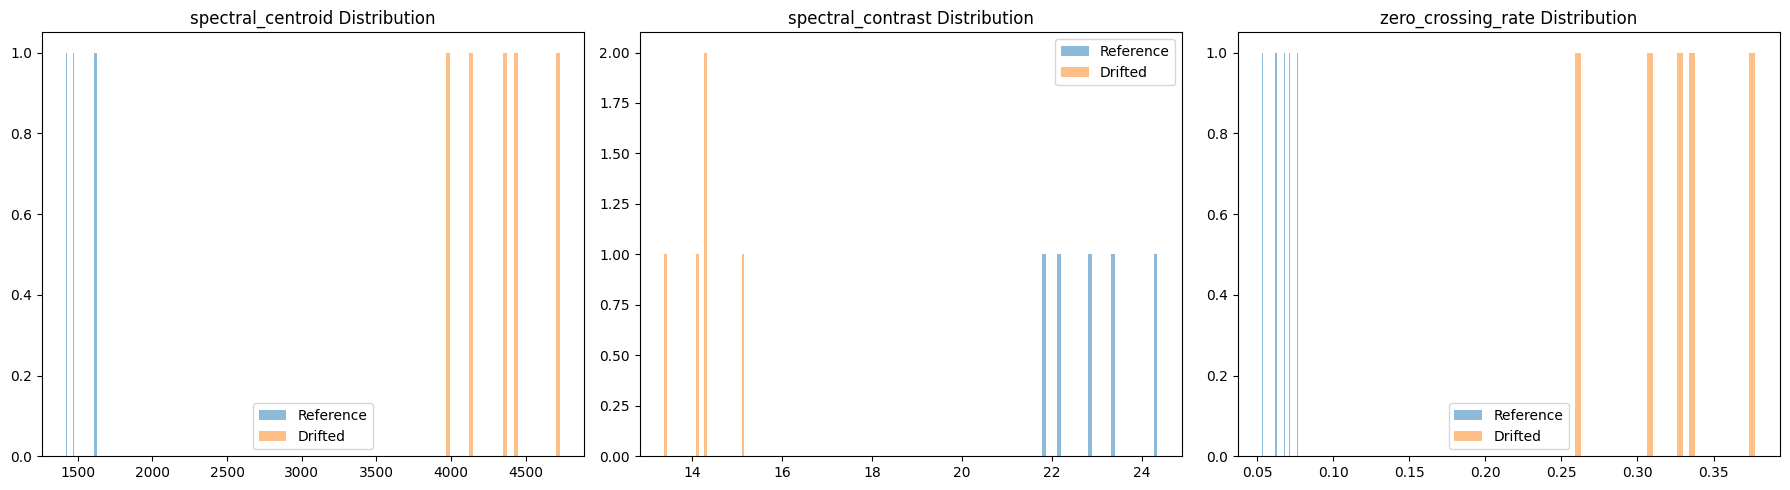

In [123]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(['spectral_centroid', 'spectral_contrast', 'zero_crossing_rate']):
    axes[i].hist(reference_data[feature], bins=30, alpha=0.5, label='Reference')
    axes[i].hist(current_data_drifted[feature], bins=30, alpha=0.5, label='Drifted')
    axes[i].set_title(f"{feature} Distribution")
    axes[i].legend()

plt.tight_layout()
plt.show()


## If Data Drift is detected send an alert!
The function **send_drift_alert** can be used to send an email to inform about the situation

In [124]:
def send_drift_alert(feature, drift_score):
    print(f"THIS IS AN EMAIL: ALERT: Drift detected in feature '{feature}' with drift score of {drift_score} (Threshold: {DRIFT_THRESHOLD})")


for feature, metrics in drift_results['metrics'][1]['result']['drift_by_columns'].items():
    drift_score = metrics['drift_score']
    is_drifted = metrics['drift_detected']
    print(is_drifted, drift_score)
    if is_drifted:
        send_drift_alert(feature, drift_score)


True 0.007936507936507936
THIS IS AN EMAIL: ALERT: Drift detected in feature 'spectral_centroid' with drift score of 0.007936507936507936 (Threshold: 0.1)
True 0.007936507936507936
THIS IS AN EMAIL: ALERT: Drift detected in feature 'spectral_contrast' with drift score of 0.007936507936507936 (Threshold: 0.1)
True 0.007936507936507936
THIS IS AN EMAIL: ALERT: Drift detected in feature 'zero_crossing_rate' with drift score of 0.007936507936507936 (Threshold: 0.1)
